In [1]:
import base64
import io
import imageio
from matplotlib import pyplot as plt

#changed from string input to file input for concise code

img1 = imageio.imread('./img1.png', format='PNG')
img2 = imageio.imread('./img2.png', format='PNG')
img3 = imageio.imread('./img3.png', format='PNG')

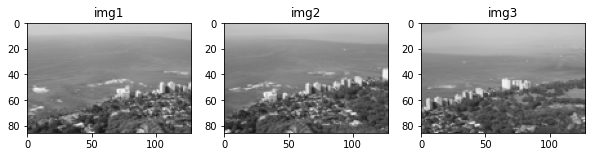

In [2]:
# View images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

ax1.imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=255)
ax1.set_title('img1')

ax2.imshow(img2, cmap=plt.cm.gray, vmin=0, vmax=255)
ax2.set_title('img2')

ax3.imshow(img3, cmap=plt.cm.gray, vmin=0, vmax=255)
ax3.set_title('img3')

plt.show()

In [3]:
# install necessary packages, use python3.7
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

You should consider upgrading via the 'c:\users\dan\isp\isp_lab\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\dan\isp\isp_lab\scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
%%capture
import numpy as np
from scipy.linalg import null_space
import cv2

def image_size(image):
    if image.ndim == 2:
        return image.shape
    else:
        return image.shape[:-1]


def sift(img1, img2):
    """
    Computes point correspondences between two images using sift

    Args:
        img1 (np.array): Query image
        img2 (np.array): Target image

    Returns:
        points (np.array): A 2 X num_matches X 2 array.
                           `points[0]` are keypoints in img1 and the corresponding
                            keypoints in img2 are `points[1]`
    """
    sift = cv2.xfeatures2d.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    correspondences = np.zeros((2, len(good_matches), 2))

    for i, match in enumerate(good_matches):
        correspondences[0, i, :] = np.flip(kp1[match.queryIdx].pt)
        correspondences[1, i, :] = np.flip(kp2[match.trainIdx].pt)

    return correspondences

# Lab 3
# Image Mosaicing

pip install opencv-python==3.4.2.16
pip install opencv-contrib-python==3.4.2.16

Instructions:

1. Proceed cell by cell. Each cell already has some code, but it is incomplete. 
2. You are required to fill in the missing details. The places where you are expected to supply code begin and end with `# <---` and `# --->` respectively.
3. Please read the comments carefully to understand what is being asked of you.
4. All the images are inside `images/` and have already been imported.
5. For question we have provided the `sift` function for your convenience. Read its documentation to understand how to use it (`print sift.__doc__`)

In [5]:
def find_homography(points):
    """
    Fits homography between 4 pairs of corresponding points
    
    Args:
        points (np.array): A 2 X 4 X 2 array.
                           `points[0]` are keypoints in img1 and the corresponding
                           keypoints in img2 are `points[1]`
    
    Returns:
        np.array: The homography
    """
    
    A = np.zeros((8, 9), dtype=np.float64)
    # Fill `A` with the correct coefficients using the values in `points`
    # <---
    A[0::2, 0:2] = points[0]
    A[1::2, 3:5] = points[0]
    A[0::2, 2] = 1
    A[1::2, 5] = 1
    A[:, -1] = -points[1].reshape(-1, order='C')
    A[0::2, 6:8] = -points[0]
    A[1::2, 6:8] = -points[0]
    A[:, 6:8] *= points[1].reshape((-1, 1), order='C')
    # --->
    try:
        # Using the `null_space` function, find the homography `H`
        # <---
        H = null_space(A).reshape((3, 3))
        # --->
    except ValueError:
        raise ValueError('Points are collinear.')
    return H

def ransac_fit(points, epsilon=10, threshold=0.8, max_attempts=50):
    """
    Computes a robust homography between a pair of point correspondences using RANSAC
    
    Args:
        points (np.array): A 2 X num_matches X 2 array.
                           `points[0]` are keypoints in img1 and the corresponding
                           keypoints in img2 are `points[1]`
        epsilon (float): margin of error
        threshold (float): fraction of inliers
        max_attempts (int): maximum number of iterations to run RANSAC
        
    Returns:
        np.array: Robust homography
    """
    
    num_points = points.shape[1]
    best_consensus = 0
    best_H = None
    for k in range(max_attempts):
        # Pick 4 pairs of points randomly
        # <---
        indices = np.random.choice(num_points, size=4)
        # --->
        try:
            # Use `find_homography` to find the homography fitting the above 4 pairs
            # <---
            H = find_homography(points[:, indices, :])
            # --->
        except ValueError:
            continue
        # Now map all the points in `img1` using `H`
        # <---
        estimates = H @ np.concatenate((points[0], np.ones((num_points, 1))), axis=-1).T
        estimates = estimates[:2, :] / estimates[2, :]
        # --->
        
        # Count the number of mapped points that are within epsilon distance of their true locations in `img2`
        # This is the consensus size.
        # <---
        consensus = np.count_nonzero(np.linalg.norm(estimates.T - points[1], axis=1) <= epsilon)
        # --->
        if consensus > threshold * num_points:
            return H
        elif consensus > best_consensus:
            best_H = H
            best_consensus = consensus
    return best_H

In [6]:
def bilinear_interpolation(source_image, source_point):
    """
    Computes the intensity at `source_point` by bilinearly interpolating
    intensities in the immediate 2 X 2 neighborhood of the `source_point`.
    
    Args:
        source_image (np.array): The source image
        source_point (float, float): The source point
        
    Returns:
        uint8: Pixel intensity at source_point
    """
    i_s, j_s = source_point
    
    
    i = int(np.floor(i_s))
    j = int(np.floor(j_s))
    
    tl = i, j
    tr = i, j + 1
    bl = i + 1, j
    br = i + 1, j + 1
    
    del_i, del_j = i_s - i, j_s - j
    
    pixel_intensity = (1 - del_i) * (1 - del_j) * source_image[tl] + \
                      (1 - del_i) * del_j * source_image[tr] + \
                      del_i * (1 - del_j) * source_image[bl] + \
                      del_i * del_j * source_image[br]
    
    return np.uint8(pixel_intensity)

def transform(source_image, transformation, target_size=None):
    """
    Transforms `source_image` as dictated by `transformation`. 
    
    Note that this function does T-S mapping. So, `transformation` is actually from Target to Source.
    
    Args:
    
        source_image (np.array): The source image
        transformation (np.array): 3 x 3 transformation matrix
        target_size (uint, uint): Size of the target_image
        
    Returns:
        np.array: Transformed image
    """
    source_rows, source_cols = image_size(source_image)
    
    # When no `target_size` is supplied, `target_image` will be the same size as `source_image`
    target_rows, target_cols = target_size if target_size else (source_rows, source_cols)
    target_image = np.zeros((target_rows, target_cols), dtype=np.uint8)
    
    # We iterate over each pixel in `target_image` and assign the appropriate intensity
    for i_t in range(target_rows):
        for j_t in range(target_cols):
            
            # Map each target point (`i_t`, `j_t`) through `transformation`
            # to obtain its corresponding source_point (`i_s`, `j_s`)
            i_s, j_s, v = np.array([i_t, j_t, 1]) @ transformation.T
            i_s, j_s = i_s / v, j_s / v
            
            # We ignore all target points whose source points lie outside the
            # source image. All these intensities remain 0.
            if 0 <= i_s < source_rows - 1 and 0 <= j_s < source_cols - 1:
                # Assign the intensity value of target_image at (i_t, j_t) using the
                # bilinear interpolation function above.
                target_image[i_t, j_t] = bilinear_interpolation(source_image, (i_s, j_s))
    
    return target_image

def mosaic(images, homographies):
    """
    Creates a mosaic from a list of images and their homographies
    
    Args:
        images ([np.array]): List of images
        homographies ([np.array]): list of 3 X 3 homographies that maps each image onto a common canvas
    
    Returns:
        np.array: A stitched mosaic
    """
    
    shape = images[0].shape
    total_width = 3 * shape[1]
    total_height = 3 * shape[0]
    # Our canvas is 9 times the size of each image
    canvas = np.zeros((total_height, total_width), dtype=np.float64)
    
    # num_references counts how many images contribute at each pixel
    num_references = np.zeros((total_height, total_width), dtype=np.float64)
    
    for image, H in zip(images, homographies):
        # Use the `transform` function to transform the current `image`.
        # Make sure that the output size is the same as that of the canvas
        # <---
        transformed_image = transform(image, H, target_size=canvas.shape)
        # --->
        # Add this `transformed_image` to the `canvas`
        # <---
        canvas += transformed_image
        # --->
        # Update `num_references` so that it accuractely reflects the pixel locations
        # the current image contributed to
        # <---
        num_references += (transformed_image != 0).astype(np.float64)
        # --->
    num_references[num_references == 0] =  1
    # Normalize the intensities in `canvas` using `num_references`
    # <---
    canvas = canvas / num_references
    # --->
    # Optionally, remove any extraeneous portions in the canvas borders
    # <---
    xs, ys = np.where(canvas != 0)
    canvas = canvas[min(xs):max(xs) + 1, min(ys):max(ys) + 1]
    # --->
    return canvas.astype(np.uint8)

In [7]:
# Use `sift` to find point correspondences from img2, img1
# <---
correspondences_21 = sift(img2, img1)
# --->
# Use `sift` to find point correspondences from img2, img1
# <---
correspondences_23 = sift(img2, img3)
# --->

# Use `ransac_fit` to find the robust homography that maps img2 to img1
# <---
H_21 = ransac_fit(correspondences_21)
# --->
# Use `ransac_fit` to find the robust homography that maps img2 to img1
H_23 = ransac_fit(correspondences_23)
# --->
print(H_21)
print(H_23)


[[ 1.79270561e-02  7.14871748e-04  1.29374239e-02]
 [-3.36102293e-03  1.84615396e-02  9.99359808e-01]
 [-2.11710032e-05 -6.89310886e-06  2.09423259e-02]]
[[ 1.26667373e-02  2.24214196e-03 -2.72558859e-01]
 [ 3.08006638e-03  1.21563757e-02 -9.61964573e-01]
 [ 3.67482524e-05  4.47644731e-05  3.61774956e-03]]


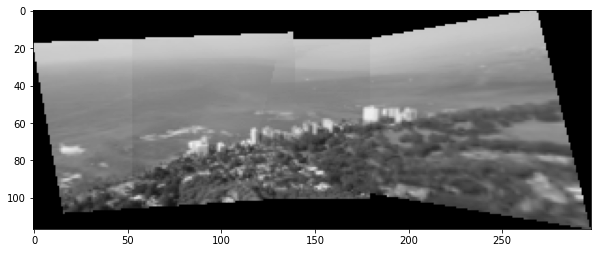

In [8]:
images = [img1, img2, img3]
# Create a homography that moves img2 to center of the canvas
# <---
offset = np.array([[1, 0, -images[0].shape[0]],
                   [0, 1, -images[0].shape[1]],
                   [0, 0, 1]])
# --->
# We apply offset on img1, img3 as well as their homographies were computed wrt img2
homographies = [H_21 @ offset, offset, H_23 @ offset]
# Use `mosaic` to stitch the 3 images
# <---
stitched_image = mosaic(images, homographies)
# --->
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(stitched_image, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()